<a href="https://www.kaggle.com/code/salommiguel/chestpneumonia-p?scriptVersionId=129579044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install tensorflow

!pip install tensorflow-addons

!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


# **Importar paquetes y módulos**

Para entrenar y evaluar un modelo de redes neuronales convolucionales para clasificiar imágenes médicas.

In [2]:
import matplotlib.pyplot as plt #Visualizar gráficos y datos en 2D
import numpy as np #Trabajar con matrices y vectores
import os# Módulo para interactuar con el sistema operativo, como leer y escribir archivos
import seaborn as sns #Paquete para visualizar gráficos estadísticos.
import keras# Biblioteca de alto nivel para construir y entrenar modelos de redes neuronales
import tensorflow as tf#aprendizaje automático
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau #módulo que contiene varias clases de callbacks (retroalimentación) útiles durante el entrenamiento de modelos de Keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization, Activation #módulo que contiene diferentes tipos de capas de redes neuronales, como convoluciones, activaciones, agrupaciones, entre otras.
from tensorflow.keras.models import Model#módulo que contiene diferentes tipos de modelos de redes neuronales, como secuenciales y funcionales.
from tensorflow_addons.optimizers import AdamW#un optimizador que extiende el algoritmo de optimización Adam con la corrección de peso de decaimiento L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator#un generador de datos de imagen que permite aumentar el tamaño del conjunto de datos mediante técnicas como el recorte, el volteo y la rotación.
from sklearn.metrics import classification_report, confusion_matrix#una función para generar un informe de clasificación que muestra varias métricas de evaluación de un modelo de clasificación. y  una función para calcular la matriz de confusión de un modelo de clasificación.

# **Generador de imágenes**

Definir el generador de imágenes de entrenamiento con aumento de datos

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,#factor de reescala para normalizar los valores de los píxeles de las imágenes.
    rotation_range=20,#un rango en grados para rotar aleatoriamente las imágenes.
    width_shift_range=0.2,#fracción de desplazamiento máximo aleatorio en anchura (horizontal).
    height_shift_range=0.2,# fracción de desplazamiento máximo aleatorio en altura (vertical).
    shear_range=0.2,#nivel de deformación aleatoria de corte.
    zoom_range=0.2,#rango aleatorio para el aumento de zoom de las imágenes.
    horizontal_flip=True,# booleano que indica si las imágenes se voltearán horizontalmente de forma aleatoria.
    fill_mode='nearest'#estrategia utilizada para llenar los bordes que se pueden crear durante la transformación de la imagen
)

# **Definición de generadores de imágenes**

Uno para el conjunto de entrenamiento y el otro para validación. En este caso nuestro "Test" es el de validación. 

In [4]:
# Definir el generador de imágenes de validación sin aumento de datos
valid_datagen = ImageDataGenerator(rescale=1./255) #el generador de imágenes se instancia con la opción de reescalar las imágenes dividiendo los valores de los píxeles por 255, para obtener valores entre 0 y 1

train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"#Ruta
valid_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"#Ruta

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),#tamaño de la imagen que se utilizará en la entrada del modelo.
    batch_size=32,#tamaño del lote de imágenes que se utilizará en cada iteración durante el entrenamiento.
    class_mode="binary"
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),#tamaño de la imagen que se utilizará en la entrada del modelo.
    batch_size=32,#
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Carga de un modelo pre-entrenado**

**Modelo pre-entrenado:** ResNet50V2 que ha sido previamente entrenado en el conjunto de datos de ImageNet

La arquitectura ResNet50V2 es una red neuronal convolucional pre-entrenada ampliamente utilizada en la clasificación de imágenes. Es una versión mejorada de la arquitectura ResNet50 original, con un enfoque en la reducción del costo computacional y la mejora de la precisión en la clasificación.

ResNet50V2 utiliza una técnica llamada "shortcut connection" para evitar el problema de degradación de la precisión en redes más profundas. Además, también utiliza una técnica llamada "identity mapping" para mejorar el flujo de información a través de la red.

In [5]:
# Cargar un modelo pre-entrenado y ajustar las últimas capas para el conjunto de datos actual
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,#se especifica que no se incluirá la última capa de clasificación del modelo pre-entrenado, ya que se desea adaptar el modelo a un problema de clasificación binaria específico.
    input_tensor=Input(shape=(224, 224, 3)),#se define el tamaño de la entrada del modelo, que coincide con el tamaño de las imágenes de entrada utilizadas en el generador de imágenes.
    weights='imagenet',# se especifica que se cargarán los pesos pre-entrenados del modelo ResNet50V2 entrenado en ImageNet.
    pooling='avg'#se especifica que se utilizará una capa de pooling global promedio para generar una representación de características a partir de las últimas características del modelo pre-entrenado.
)

x = base_model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# se define la arquitectura de la red neuronal agregando capas adicionales para adaptar el modelo a un problema de clasificación binaria. En este caso, se agrega una capa densa de 512 unidades con activación ReLU y una capa de dropout para reducir el sobreajuste. Por último, se agrega una capa densa con una unidad y activación sigmoide para generar la salida de clasificación binaria.

94668760/94668760 [==============================] - 1s 0us/step


# **Congelar las capas del modelo pre-entrenado para evitar que se modifiquen durante el entrenamiento**

Esto se hace para que los pesos de las capas pre-entrenadas no se modifiquen y para que el modelo pre-entrenado pueda servir como una buena "base" para la tarea actual, que es la clasificación de radiografías de tórax en "normal" o "neumonía". Al congelar las capas, el modelo se entrena solo en las nuevas capas que se agregaron y en las capas de clasificación que se han añadido para la tarea actual.

In [6]:
for layer in base_model.layers:
    layer.trainable = False

# **Definir callbacks**

In [7]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)#Este callback detiene el entrenamiento del modelo si no se observa una mejora en la métrica de validación después de un cierto número de épocas. patience es el número de épocas sin mejora antes de detener el entrenamiento, y restore_best_weights es un parámetro que se establece en verdadero para restaurar los pesos del modelo a la mejor época antes de detener el entrenamiento
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)#Este callback guarda los pesos del modelo en un archivo cada vez que se alcanza una nueva mejor métrica de validación. best_model.h5 es el nombre del archivo donde se guardarán los pesos.
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, verbose=1)
#Este callback reduce la tasa de aprendizaje del modelo si no se observa una mejora en la métrica de validación después de un cierto número de épocas. factor es el factor por el cual se reducirá la tasa de aprendizaje, patience es el número de épocas sin mejora antes de reducir la tasa de aprendizaje y verbose es un parámetro que indica si se mostrarán mensajes cuando se reduzca la tasa de aprendizaje.

# **Compilar el modelo**

In [8]:
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)#es el algoritmo de optimización que se utilizará para ajustar los pesos del modelo durante el entrenamiento. En este caso, se está utilizando el optimizador AdamW con una tasa de aprendizaje de 1e-4 y una decaimiento de peso de 1e-4.
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])#es el método que compila el modelo para su entrenamiento. Aquí, se está definiendo la función de pérdida a optimizar como la entropía cruzada binaria y se está monitoreando la precisión (accuracy) como una métrica.

# **Entrenar el modelo**

In [9]:
history = model.fit( #Es el método de Keras que se utiliza para entrenar un modelo.
train_generator,#Es el generador de datos de entrenamiento
epochs=20,#Número de épocas de entrenamiento que se quieren realizar.
steps_per_epoch=len(train_generator),#Número de pasos que se quieren realizar en cada época de entrenamiento. En este caso se establece con el número de lotes generados por el generador de datos de entrenamiento (es decir, len(train_generator)).
validation_data=valid_generator,#Datos de validación para evaluar el rendimiento del modelo en cada época de entrenamiento.
validation_steps=len(valid_generator),#Número de pasos que se quieren realizar en cada época de validación. En este caso se establece con el número de lotes generados por el generador de datos de validación (es decir, len(valid_generator)).
callbacks=[early_stopping, model_checkpoint, reduce_lr]
)
#En este caso se utilizan tres: EarlyStopping (para detener el entrenamiento si el modelo no mejora después de un número determinado de épocas), ModelCheckpoint (para guardar el mejor modelo obtenido durante el entrenamiento) y ReduceLROnPlateau (para reducir la tasa de aprendizaje si el modelo deja de mejorar durante un número determinado de épocas).

Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.8727
Epoch 1: val_loss improved from inf to 0.28457, saving model to best_model.h5
163/163 [==============================] - 180s 1s/step - loss: 0.2860 - accuracy: 0.8727 - val_loss: 0.2846 - val_accuracy: 0.8846 - lr: 1.0000e-04
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9204
Epoch 2: val_loss improved from 0.28457 to 0.27108, saving model to best_model.h5
163/163 [==============================] - 135s 829ms/step - loss: 0.1865 - accuracy: 0.9204 - val_loss: 0.2711 - val_accuracy: 0.8910 - lr: 1.0000e-04
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9352
Epoch 3: val_loss improved from 0.27108 to 0.24677, saving model to best_model.h5
163/163 [==============================] - 130s 796ms/step - loss: 0.1643 - accuracy: 0.9352 - val_loss: 0.2468 - val_accuracy: 0.9087 - lr: 1.0000e-04
Epoch 4/20
163/16

In [10]:
# Guardar el modelo
model_name = 'my_model.h5'
model.save(model_name)

20/20 [==============================] - 9s 395ms/step


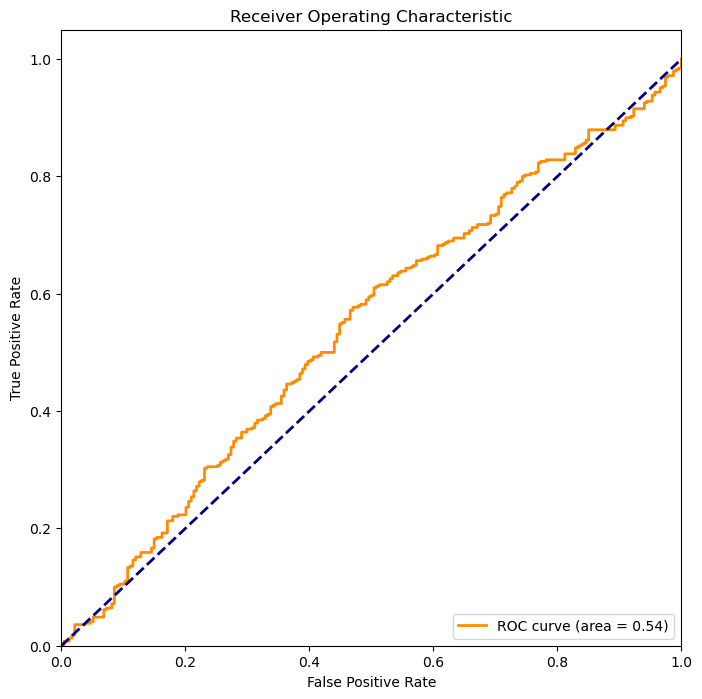

In [11]:
from sklearn.metrics import roc_curve, auc 
# Plot ROC curve
y_true = valid_generator.classes
y_pred = model.predict(valid_generator)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **Grafica de la curva de aprendizaje**

Muestra cómo la pérdida y la precisión (accuracy) del modelo cambian durante el entrenamiento y la validación a través de las épocas.

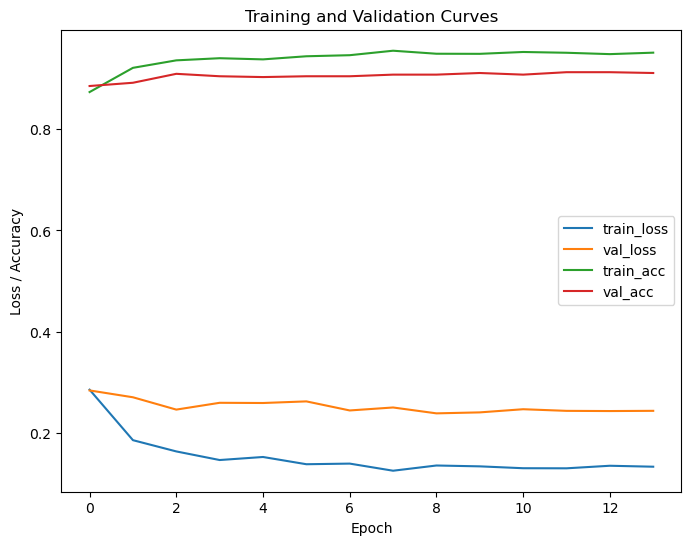

In [12]:
plt.figure(figsize=(8, 6)) # crea una nueva figura de tamaño 8x6 pulgadas.
plt.plot(history.history['loss'], label='train_loss')#traza la pérdida del conjunto de entrenamiento en función del número de épocas, donde history.history['loss'] son las pérdidas registradas durante el entrenamiento. Lo mismo ocurre con val_loss, que traza la pérdida de validación.
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')#traza la precisión del conjunto de entrenamiento en función del número de épocas, donde history.history['accuracy'] son las precisión registradas durante el entrenamiento. Lo mismo ocurre con val_acc, que traza la precisión de validación.
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Curves')
plt.show()

# **Evaluar el modelo en el conjunto de prueba**

In [13]:
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(224, 224),
batch_size=32,
class_mode="binary",
shuffle=False
)

model.evaluate(test_generator) #Esto devuelve la pérdida y la precisión del modelo en el conjunto de prueba.

Found 16 images belonging to 2 classes.
1/1 [==============================] - 0s 262ms/step - loss: 0.2340 - accuracy: 0.9375


[0.2339583784341812, 0.9375]

# **Evaluación del desempeño del modelo y generación de matriz de confusión.**

1/1 [==============================] - 0s 239ms/step


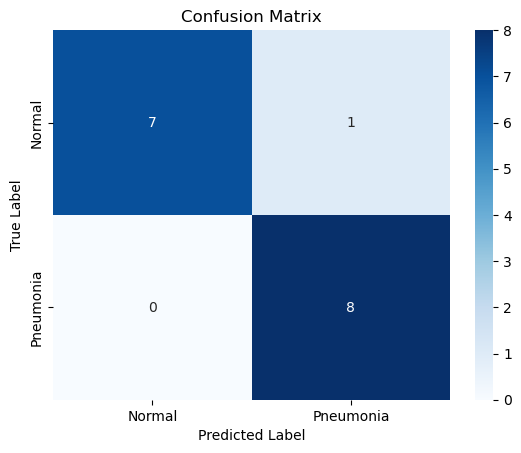

In [14]:
test_generator.reset()
y_pred = model.predict(test_generator)#se utilizan las imágenes de prueba para obtener las predicciones de salida del modelo.
y_pred = np.round(y_pred).flatten() #redondea los valores de las predicciones a 0 o 1 para obtener las etiquetas predichas.
y_true = test_generator.classes#devuelve las etiquetas verdaderas de las imágenes del conjunto de prueba.
cm = confusion_matrix(y_true, y_pred)

#TN, FP, FN, TP = cm.ravel()

#sensibilidad = TP / (TP + FN)
#especificidad = TN / (TN + FP)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
#plt.text(0, 0.9, f'Sensibilidad: {sensibilidad:.2f}', fontsize=12)
#plt.text(0, 1, f'Especificidad: {especificidad:.2f}', fontsize=12)
plt.show()

# **Informe de clasificación**

In [15]:
# Mostrar el informe de clasificación
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       1.00      0.88      0.93         8
   Pneumonia       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



# **Evaluando una imagen propia del dataset**

In [16]:
import requests
from skimage import transform

1/1 [==============================] - 1s 1s/step


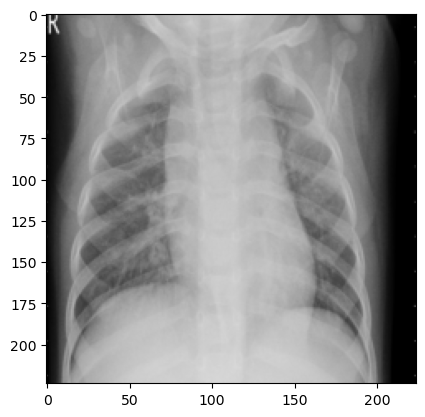

In [17]:
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg')
model.predict(image)
plt.imshow(image[0])
plt.show()

# **Evaluando con una imagen fuera del dataset original**

Función para cargar una imagen propia

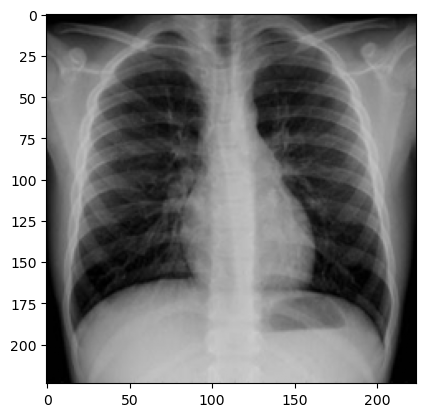

In [18]:
url = 'https://faros.hsjdbcn.org/sites/default/files/styles/ficha-contenido/public/radiografia_de_torax_-_imagen_-.jpg?itok=-Nikjhh3'
response = requests.get(url, stream=True)
response.raw.decode_content = True                    # Redimensionar imagen al tamaño de entrada del modelo
img = Image.open(response.raw).resize((224, 224))
# Convertir imagen a un array y normalizar valores de pixel entre 0 y 1
img_array = np.array(img) / 255.0
# Agregar una dimensión adicional para representar el lote
img_array = np.expand_dims(img_array, axis=0) 
plt.imshow(img_array[0])
plt.show()

In [19]:
# Cargar el modelo pre-entrenado y hacer una predicción en la imagen de entrada
model = tf.keras.models.load_model('/kaggle/working/my_model.h5')
prediction = model.predict(img_array)

1/1 [==============================] - 1s 868ms/step


In [20]:
prediction

array([[0.701684]], dtype=float32)

In [21]:
# Muestra la predicción
if prediction[0] < 0.5:
    print('La imagen es Normal')
else:
    print('La imagen es Neumonia')

La imagen es Neumonia
